<a href="https://colab.research.google.com/github/Tam107/MAIN_BDM/blob/main/Good_EE_RF_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1: Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("Libraries imported successfully")

Libraries imported successfully


Cell 2: Dataset - Load Data

In [ ]:
# Load the dataset with the original columns
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated',
    'vehicleType', 'fuelType', 'notRepairedDamage'
]
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)

print("Dataset loaded:")
print(data.head())

Dataset loaded:
     price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480.0         NaN              1993.0    manuell      0.0   golf   
1  18300.0       coupe              2011.0    manuell    190.0    NaN   
2   9800.0         suv              2004.0  automatik    163.0  grand   
3   1500.0  kleinwagen              2001.0    manuell     75.0   golf   
4   3600.0  kleinwagen              2008.0    manuell     69.0  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0   150000.0                  0.0   benzin  volkswagen               NaN   
1   125000.0                  5.0   diesel        audi                ja   
2   125000.0                  8.0   diesel        jeep               NaN   
3   150000.0                  6.0   benzin  volkswagen              nein   
4    90000.0                  7.0   diesel       skoda              nein   

           dateCreated  
0  2016-03-24 00:00:00  
1  2016-03-24 00:00:00  
2  2016-03-14

Cell 3: Preprocessing - Missing Values, Feature Engineering, Scaling

In [ ]:
# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')
data['vehicleType'] = data['vehicleType'].fillna('unknown')
data['fuelType'] = data['fuelType'].fillna('unknown')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('nein')

# Feature engineering
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data['powerPS_per_km'] = data['powerPS'] / (data['kilometer'] + 1)
data['age_km_interaction'] = data['car_age'] * data['kilometer']
data['is_damaged'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0})
data = data.drop(columns=['dateCreated', 'yearOfRegistration', 'notRepairedDamage'])

# Ensure categorical columns are strings
for col in ['brand', 'model', 'gearbox', 'vehicleType', 'fuelType']:
    data[col] = data[col].astype(str)

# Dummies for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'], prefix='gearbox')
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model', 'vehicleType', 'fuelType']]

# Filter price > 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Check for NaN or inf values in numeric columns
print("Checking for NaN or inf values before scaling:")
print(data[numeric_cols].isna().sum())
print(data[numeric_cols].replace([np.inf, -np.inf], np.nan).isna().sum())

# Replace inf with a large finite value and NaN with median
for col in numeric_cols:
    data[col] = data[col].replace([np.inf, -np.inf], np.nan)
    data[col] = data[col].fillna(data[col].median())

# Scale numeric features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Scale price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

print("\nProcessed data:")
print(data.head())

Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0
Checking for NaN or inf values before scaling:
powerPS                0
kilometer              0
monthOfRegistration    0
adYear                 0
car_age                0
powerPS_per_km         0
age_km_interaction     0
is_damaged             0
gearbox_automatik      0
gearbox_manual         0
gearbox_manuell        0
dtype: int64
powerPS                0
kilometer              0
monthOfRegistration    0
adYear                 0
car_age                0
powerPS_per_km         0
age_km_interaction     0
is_damaged             0
gearbox_automatik      0
gearbox_manual         0
gearbox_manuell        0
dtype: int64
Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

Processed data:
      price vehicleType   po

Cell 4: Train-Test Split

In [ ]:
# Split data into train, validation, and test sets
X = data.drop(['price'], axis=1).copy()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Tập huấn luyện có 230880 bản ghi và 15 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


Cell 5: Prepare Inputs for RF and MLP with Entity Embedding

In [ ]:
# Integer-encode categorical variables for embedding
cat_cols = ['brand', 'model', 'vehicleType', 'fuelType']
cat_encoders = {}
embedded_features = {}
for col in cat_cols:
    unique_vals = X_train_new[col].unique()
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_vals)}
    X_train_new[col] = X_train_new[col].map(cat_encoders[col]).astype(np.int32)
    X_val[col] = X_val[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    X_test[col] = X_test[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    n_unique = len(unique_vals)
    # Use original embedding dimensions
    if col == 'brand':
        emb_dim = 8
    elif col == 'model':
        emb_dim = 15
    elif col == 'vehicleType':
        emb_dim = 5
    else:  # fuelType
        emb_dim = 4
    embedded_features[col] = (n_unique, emb_dim)
    print(f'\nCó {n_unique} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

# Numeric features (including gearbox dummies)
num_cols = [col for col in X_train_new.columns if col not in cat_cols]

# Train a neural network to learn embeddings
inputs = []
emb_layers = []
for col in cat_cols:
    n_unique, emb_dim = embedded_features[col]
    inp = Input(shape=(1,), name=f'input_{col}')
    emb = Embedding(input_dim=n_unique, output_dim=emb_dim, name=f'embedding_{col}')(inp)
    emb = Reshape(target_shape=(emb_dim,))(emb)
    inputs.append(inp)
    emb_layers.append(emb)

inp_num = Input(shape=(len(num_cols),), name='input_num')
inputs.append(inp_num)

x = Concatenate()(emb_layers + [inp_num])
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

embedding_model = Model(inputs=inputs, outputs=output)
embedding_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Prepare inputs for training embeddings
train_inputs = [X_train_new[col].values for col in cat_cols] + [X_train_new[num_cols].values]
val_inputs = [X_val[col].values for col in cat_cols] + [X_val[num_cols].values]
test_inputs = [X_test[col].values for col in cat_cols] + [X_test[num_cols].values]

# Train the model to learn embeddings
embedding_model.fit(train_inputs, y_train_new, validation_data=(val_inputs, y_val), epochs=10, batch_size=512, verbose=1)

# Extract embeddings
embedding_dict = {}
for col in cat_cols:
    emb_layer = embedding_model.get_layer(f'embedding_{col}')
    embedding_dict[col] = emb_layer.get_weights()[0]

# Transform categorical features into embedded vectors
X_train_embedded = []
X_val_embedded = []
X_test_embedded = []
for col in cat_cols:
    emb_matrix = embedding_dict[col]
    train_emb = emb_matrix[X_train_new[col].values]
    val_emb = emb_matrix[X_val[col].values]
    test_emb = emb_matrix[X_test[col].values]
    X_train_embedded.append(train_emb)
    X_val_embedded.append(val_emb)
    X_test_embedded.append(test_emb)

# Concatenate with numeric features
X_train_embedded = np.hstack(X_train_embedded + [X_train_new[num_cols].values])
X_val_embedded = np.hstack(X_val_embedded + [X_val[num_cols].values])
X_test_embedded = np.hstack(X_test_embedded + [X_test[num_cols].values])

# Convert target variables to float32
y_train_new = y_train_new.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

print("Shape of embedded training data:", X_train_embedded.shape)
print("Shape of embedded validation data:", X_val_embedded.shape)
print("Shape of embedded test data:", X_test_embedded.shape)


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 250 giá trị duy nhất trong cột model trong tập huấn luyện.

Có 9 giá trị duy nhất trong cột vehicleType trong tập huấn luyện.

Có 8 giá trị duy nhất trong cột fuelType trong tập huấn luyện.
Epoch 1/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0281 - val_loss: 0.0079
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 5/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 6/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 7/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 8/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 9/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

Cell 6: Prepare Data for Hybrid Model (Adjusted)

In [ ]:
# Prepare inputs for hybrid model
input_list_train_new = [X_train_embedded]
input_list_val = [X_val_embedded]
input_list_test = [X_test_embedded]

print("Hybrid model input shape (training, embedded features):", input_list_train_new[0].shape)

Hybrid model input shape (training, embedded features): (230880, 43)


Cell 7: Random Forest - Train with Entity Embedding Output

In [ ]:
# Train Random Forest on embedded data
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_embedded, y_train_new)

# Generate RF predictions
rf_train_preds = rf.predict(X_train_embedded).astype(np.float32)
rf_val_preds = rf.predict(X_val_embedded).astype(np.float32)
rf_test_preds = rf.predict(X_test_embedded).astype(np.float32)

print("Random Forest training completed.")
print("Sample RF predictions (test):", rf_test_preds[:5])

Random Forest training completed.
Sample RF predictions (test): [0.23011912 0.10989606 0.37100235 0.39608416 0.02350771]


Cell 8: Hybrid EE+RF+MLP Model (Adjusted)


Epoch 1/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3956 - mae: 0.0579 - val_loss: 0.0362 - val_mae: 0.1539 - learning_rate: 0.0020
Epoch 2/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0043 - mae: 0.0342 - val_loss: 0.0109 - val_mae: 0.0692 - learning_rate: 0.0020
Epoch 3/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0035 - mae: 0.0320 - val_loss: 0.0058 - val_mae: 0.0420 - learning_rate: 0.0020
Epoch 4/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0034 - mae: 0.0319 - val_loss: 0.0076 - val_mae: 0.0489 - learning_rate: 0.0020
Epoch 5/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0033 - mae: 0.0319 - val_loss: 0.0110 - val_mae: 0.0584 - learning_rate: 0.0020
Epoch 6/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0033 - mae: 0.0320 - val_loss: 0.0058 - val_mae: 0.0411 - learning_rate: 0.0020
Epoch 7/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0034 - mae: 0.0321 - val_loss: 0.0081 - val_mae: 0.0536 - learning_rate:

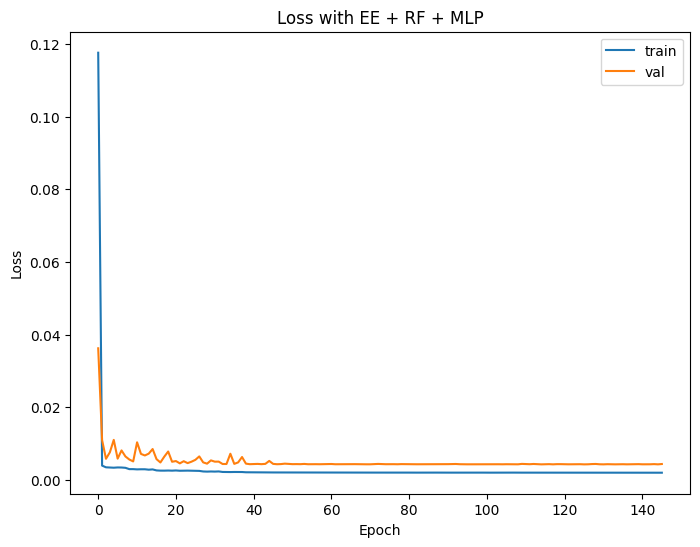

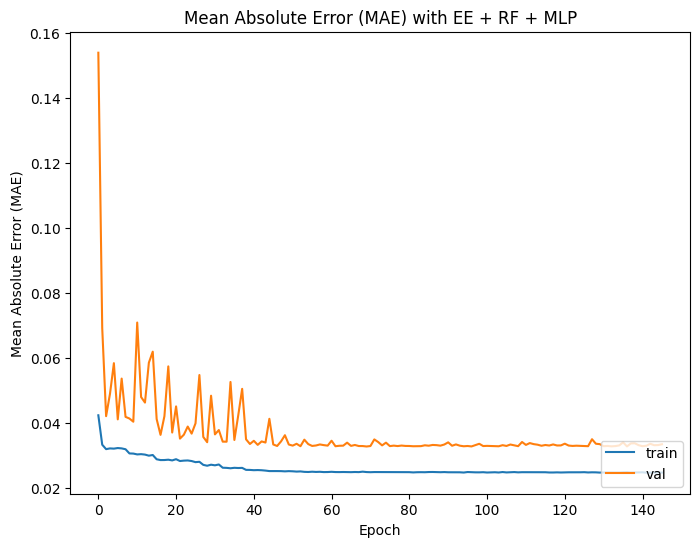

In [ ]:
# Define hybrid EE+RF+MLP using the same embedded input
input_brand = Input(shape=(1,), name='input_brand')
emb_brand = Embedding(input_dim=embedded_features['brand'][0], output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,), name='input_model')
emb_model = Embedding(input_dim=embedded_features['model'][0], output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,), name='input_vehicleType')
emb_vehicleType = Embedding(input_dim=embedded_features['vehicleType'][0], output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,), name='input_fuelType')
emb_fuelType = Embedding(input_dim=embedded_features['fuelType'][0], output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(num_cols),), name='input_numeric')
input_rf = Input(shape=(1,), name='input_rf')

input_data = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric, input_rf]
emb_data = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, input_numeric, input_rf]

model_data = Concatenate()(emb_data)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(model_data)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
outputs = Dense(1, activation='sigmoid')(x)

ee_rf_mlp = Model(inputs=input_data, outputs=outputs, name='EE_RF_MLP')
ee_rf_mlp.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.002), metrics=['mae'])

# Prepare inputs with RF predictions
input_list_train_new_rf = [X_train_new['brand'].values, X_train_new['model'].values, X_train_new['vehicleType'].values, X_train_new['fuelType'].values, X_train_new[num_cols].values, rf_train_preds.reshape(-1, 1)]
input_list_val_rf = [X_val['brand'].values, X_val['model'].values, X_val['vehicleType'].values, X_val['fuelType'].values, X_val[num_cols].values, rf_val_preds.reshape(-1, 1)]
input_list_test_rf = [X_test['brand'].values, X_test['model'].values, X_test['vehicleType'].values, X_test['fuelType'].values, X_test[num_cols].values, rf_test_preds.reshape(-1, 1)]

# Train the hybrid model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-05)

history_ee_rf_mlp = ee_rf_mlp.fit(
    input_list_train_new_rf,
    y_train_new,
    validation_data=(input_list_val_rf, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Generate predictions
ee_rf_mlp_preds = ee_rf_mlp.predict(input_list_test_rf).flatten()

# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history_ee_rf_mlp.history['loss'], label='Training Loss')
plt.plot(history_ee_rf_mlp.history['val_loss'], label='Validation Loss')
plt.title('Loss with EE + RF + MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_ee_rf_mlp.history['mae'], label='Training MAE')
plt.plot(history_ee_rf_mlp.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with EE + RF + MLP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 9: Evaluation

Evaluation Metrics for EE+RF+MLP:
       EE_RF_MLP
MSE    5000740.0
RMSE  2236.23344
R2      0.892947
MAPE   34.708584


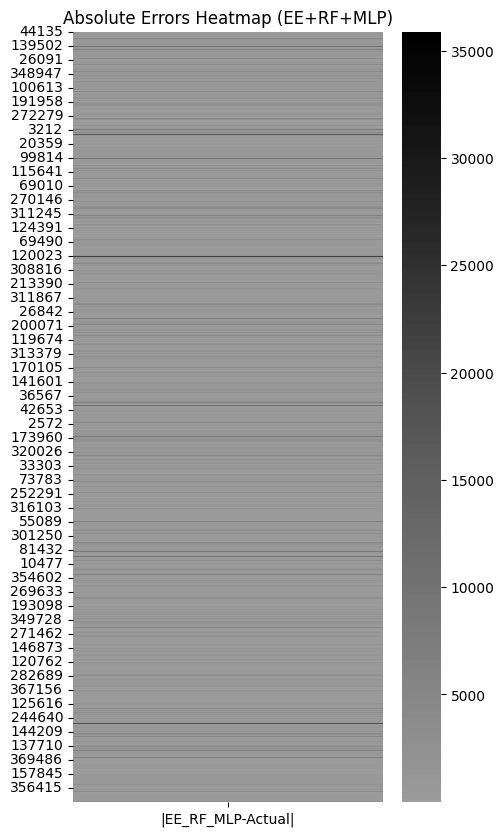

In [ ]:
# Inverse transform predictions and actual values
y_test_predict_ee_rf_mlp = price_scaler.inverse_transform(ee_rf_mlp_preds.reshape(-1, 1)).flatten()
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['EE_RF_MLP', 'Actual'])
result_df['Actual'] = y_test_original
result_df['EE_RF_MLP'] = y_test_predict_ee_rf_mlp

# Define metric calculation function
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1000))) * 100
    return mse, rmse, r2, mape

# Calculate metrics for hybrid model
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'R2', 'MAPE'], columns=['EE_RF_MLP'])
mse, rmse, r2, mape = calculate_metrics(result_df['Actual'], result_df['EE_RF_MLP'])
metric_df.at['MSE', 'EE_RF_MLP'] = mse
metric_df.at['RMSE', 'EE_RF_MLP'] = rmse
metric_df.at['R2', 'EE_RF_MLP'] = r2
metric_df.at['MAPE', 'EE_RF_MLP'] = mape

print("Evaluation Metrics for EE+RF+MLP:")
print(metric_df)

# Heatmap of absolute errors
result_df['|EE_RF_MLP-Actual|'] = np.abs(result_df['EE_RF_MLP'] - result_df['Actual'])
table = result_df[['|EE_RF_MLP-Actual|']]
plt.figure(figsize=(5, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap (EE+RF+MLP)')
plt.show()

Cell 10: Evaluation with Enhanced Visualizations

Problem with lower car price



Evaluation Metrics for EE+RF+MLP:
       EE_RF_MLP
MSE    5000740.0
RMSE  2236.23344
R2      0.892947
MAPE   34.708584

Sample Prediction Results ( Samples):
           EE_RF_MLP        Actual   Difference
44135    8526.987305   8299.000000  -227.987305
64221    4138.030273   6498.999512  2360.969238
223484  13429.838867  12950.000000  -479.838867


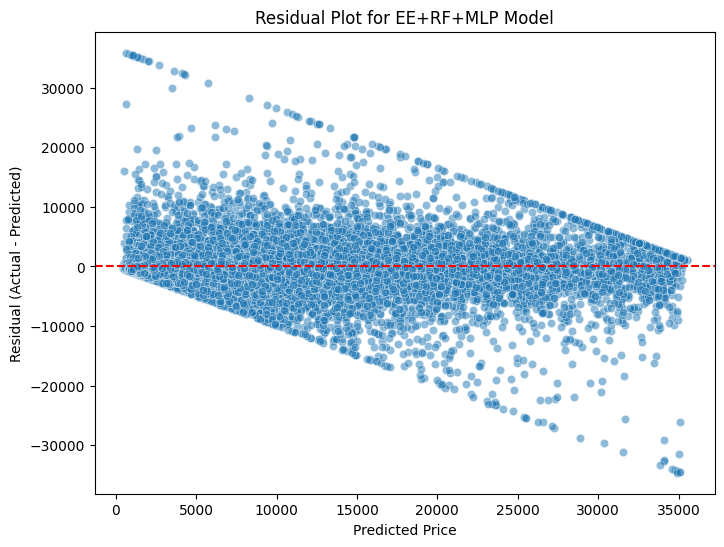

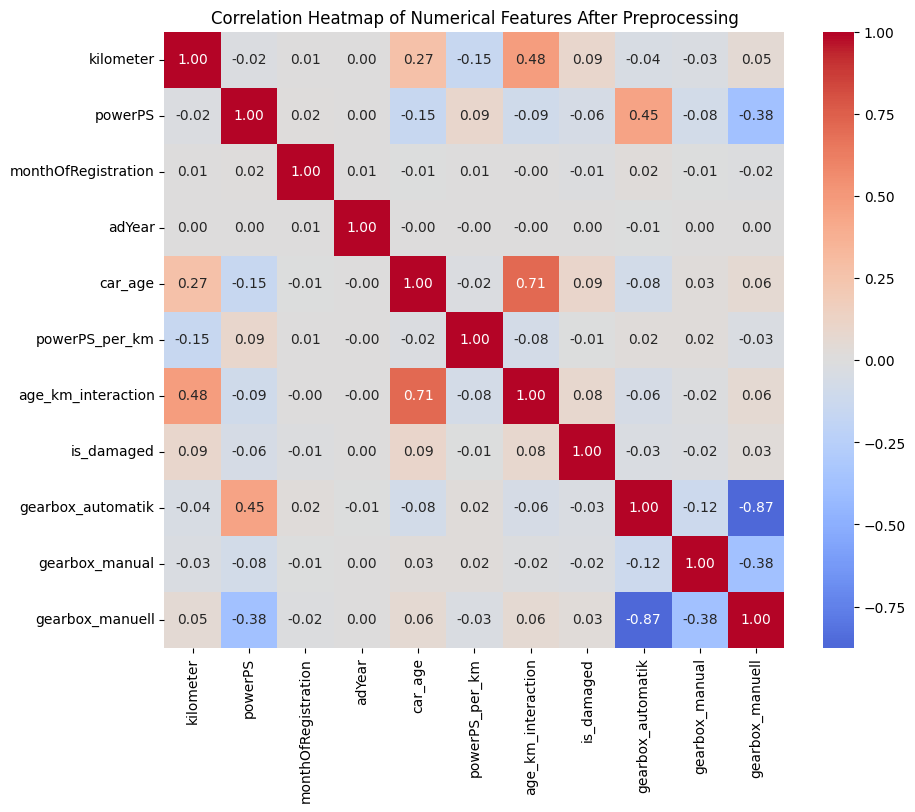


Summary of Embedded Categorical Features:
brand: 40 unique values, embedded into 8 dimensions
model: 250 unique values, embedded into 15 dimensions
vehicleType: 9 unique values, embedded into 5 dimensions
fuelType: 8 unique values, embedded into 4 dimensions


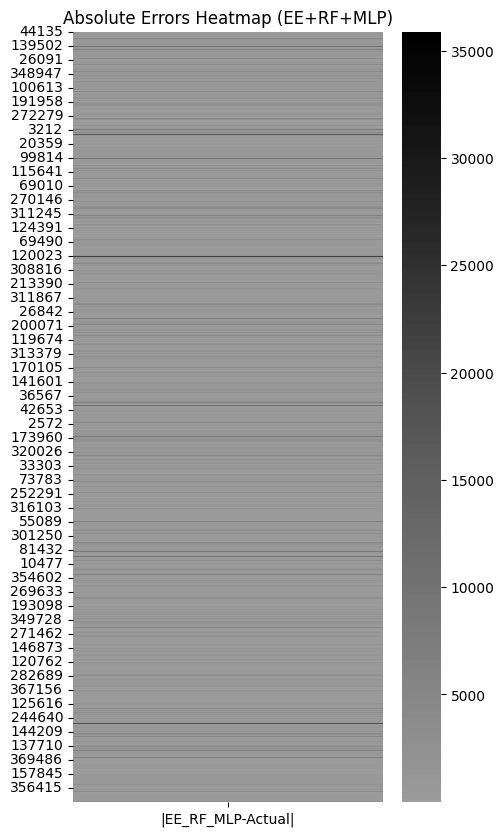

In [ ]:
# Inverse transform predictions and actual values
y_test_predict_ee_rf_mlp = price_scaler.inverse_transform(ee_rf_mlp_preds.reshape(-1, 1)).flatten()
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['EE_RF_MLP', 'Actual'])
result_df['Actual'] = y_test_original
result_df['EE_RF_MLP'] = y_test_predict_ee_rf_mlp

# Define metric calculation function
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1000))) * 100
    return mse, rmse, r2, mape

# Calculate metrics for hybrid model
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'R2', 'MAPE'], columns=['EE_RF_MLP'])
mse, rmse, r2, mape = calculate_metrics(result_df['Actual'], result_df['EE_RF_MLP'])
metric_df.at['MSE', 'EE_RF_MLP'] = mse
metric_df.at['RMSE', 'EE_RF_MLP'] = rmse
metric_df.at['R2', 'EE_RF_MLP'] = r2
metric_df.at['MAPE', 'EE_RF_MLP'] = mape

print("Evaluation Metrics for EE+RF+MLP:")
print(metric_df)

# 1. Show more prediction results: Sample of actual vs. predicted prices
print("\nSample Prediction Results ( Samples):")
sample_results = result_df.head(3).copy()
sample_results['Difference'] = sample_results['Actual'] - sample_results['EE_RF_MLP']
print(sample_results)

# 2. Residual Plot: Actual - Predicted vs. Predicted
result_df['Residual'] = result_df['Actual'] - result_df['EE_RF_MLP']
plt.figure(figsize=(8, 6))
sns.scatterplot(x=result_df['EE_RF_MLP'], y=result_df['Residual'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot for EE+RF+MLP Model')
plt.show()

# 3. Heatmap After Preprocessing
# Numerical features correlation matrix
num_cols = ['kilometer', 'powerPS', 'monthOfRegistration', 'adYear', 'car_age',
            'powerPS_per_km', 'age_km_interaction', 'is_damaged',
            'gearbox_automatik', 'gearbox_manual', 'gearbox_manuell']
num_data = X_test[num_cols]
corr_matrix = num_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features After Preprocessing')
plt.show()

# Summary of embedded categorical features
print("\nSummary of Embedded Categorical Features:")
for col in ['brand', 'model', 'vehicleType', 'fuelType']:
    n_unique, emb_dim = embedded_features[col]
    print(f"{col}: {n_unique} unique values, embedded into {emb_dim} dimensions")

# Heatmap of absolute errors (existing)
result_df['|EE_RF_MLP-Actual|'] = np.abs(result_df['EE_RF_MLP'] - result_df['Actual'])
table = result_df[['|EE_RF_MLP-Actual|']]
plt.figure(figsize=(5, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap (EE+RF+MLP)')
plt.show()

Shape of X_test_subset_stacked: (500, 16)
Shape of background_data: (50, 16)
Feature names: ['brand', 'model', 'vehicleType', 'fuelType', 'kilometer', 'powerPS', 'monthOfRegistration', 'adYear', 'car_age', 'powerPS_per_km', 'age_km_interaction', 'is_damaged', 'gearbox_automatik', 'gearbox_manual', 'gearbox_manuell', 'rf_prediction']


  0%|          | 0/500 [00:00<?, ?it/s]

Shape of shap_values: (500, 16)
Mean absolute SHAP values per feature: [1.01882935e-03 2.57821842e-03 1.53198012e-03 8.93726830e-04
 5.95382613e-03 2.23388180e-03 1.05665499e-03 0.00000000e+00
 1.71704125e-03 9.32392688e-07 2.73371317e-06 1.94653102e-03
 4.14400938e-04 2.55142993e-04 3.36955645e-04 1.10832194e-01]


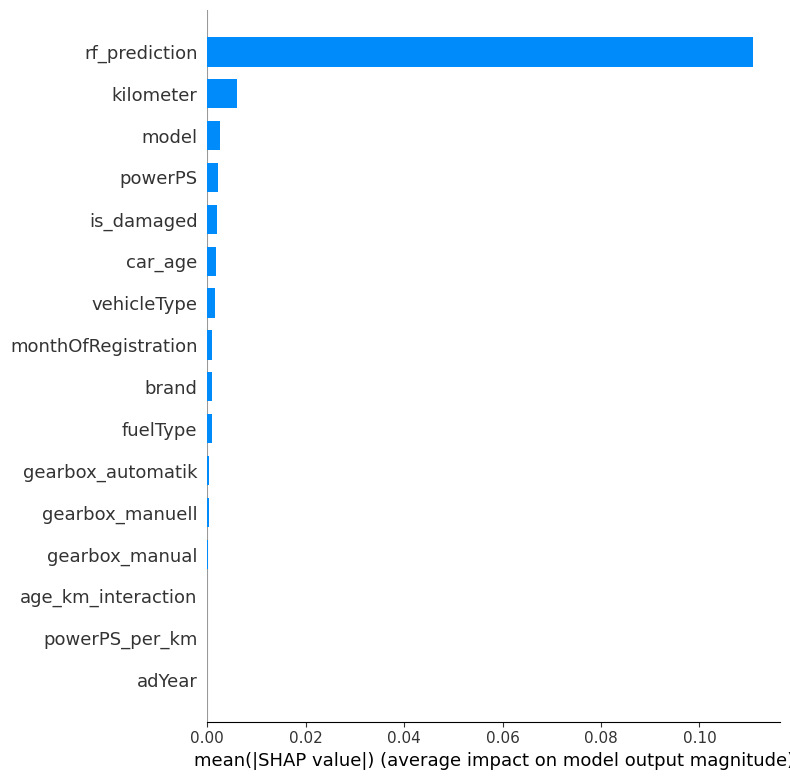

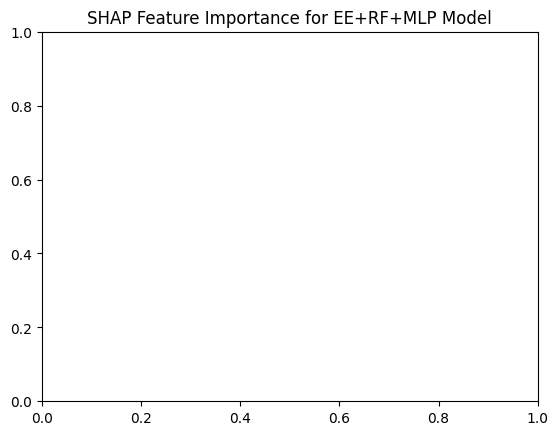

<Figure size 1000x600 with 0 Axes>

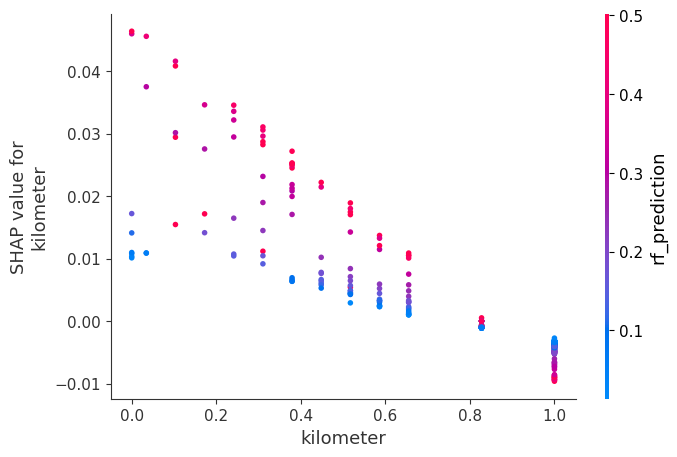

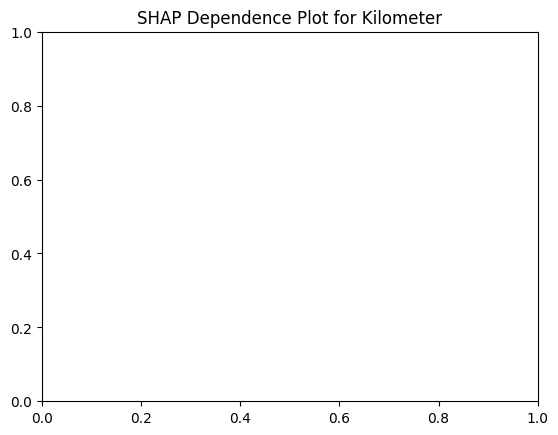

Average predicted price (scaled): 0.1247
Average predicted price: 4,708.23 euros
Average actual price (subset): 5,862.33 euros

Feature: kilometer


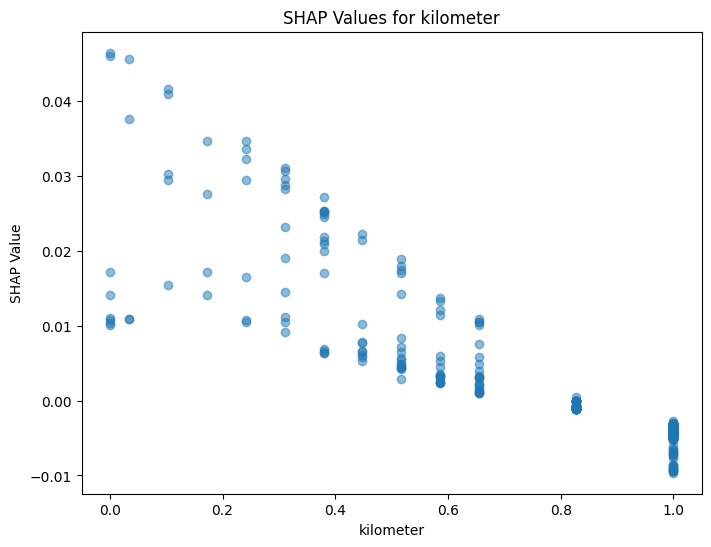


Feature: rf_prediction


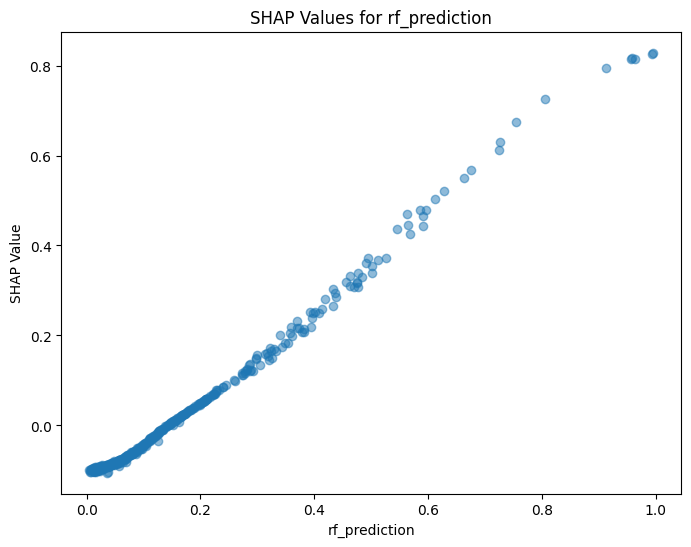

In [ ]:
# Cell 9.5: Simplified SHAP Analysis for Interpretability

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare a smaller subset of test data for SHAP
subset_size = 500  # Reduced from 1000
X_test_subset = [X_test['brand'].values[:subset_size],
                 X_test['model'].values[:subset_size],
                 X_test['vehicleType'].values[:subset_size],
                 X_test['fuelType'].values[:subset_size],
                 X_test[num_cols].values[:subset_size],
                 rf_test_preds[:subset_size].reshape(-1, 1)]

# Convert to a single array for SHAP
X_test_subset_stacked = np.hstack([arr.reshape(len(arr), -1) for arr in X_test_subset])
print("Shape of X_test_subset_stacked:", X_test_subset_stacked.shape)

# Summarize background data with fewer samples
background_data = shap.sample(X_test_subset_stacked, 50)  # Reduced from 100
print("Shape of background_data:", background_data.shape)

# Feature names
feature_names = ['brand', 'model', 'vehicleType', 'fuelType'] + num_cols + ['rf_prediction']
print("Feature names:", feature_names)

# Define a prediction function for the EE+RF+MLP model
def model_predict(inputs):
    split_indices = [1, 1, 1, 1, len(num_cols), 1]
    cum_indices = np.cumsum(split_indices)[:-1]
    inputs_split = np.split(inputs, cum_indices, axis=1)
    preds = ee_rf_mlp.predict(inputs_split, verbose=0).flatten()
    return preds

# Use KernelExplainer with fewer samples for speed
explainer = shap.KernelExplainer(model_predict, background_data)
shap_values = explainer.shap_values(X_test_subset_stacked, nsamples=200)  # Reduced from 1000
print("Shape of shap_values:", np.array(shap_values).shape)
print("Mean absolute SHAP values per feature:", np.abs(shap_values).mean(axis=0))

# Simple bar plot for feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, features=X_test_subset_stacked, feature_names=feature_names, plot_type="bar")
plt.title("SHAP Feature Importance for EE+RF+MLP Model")
plt.show()

# Dependence plot for 'kilometer' only (simplified)
plt.figure(figsize=(10, 6))
shap.dependence_plot('kilometer', shap_values, X_test_subset_stacked, feature_names=feature_names)
plt.title("SHAP Dependence Plot for Kilometer")
plt.show()

# Average predictions and actual prices
expected_value = explainer.expected_value
print(f"Average predicted price (scaled): {expected_value:.4f}")
avg_pred_price = price_scaler.inverse_transform([[expected_value]])[0][0]
print(f"Average predicted price: {avg_pred_price:,.2f} euros")
avg_actual_price = price_scaler.inverse_transform(y_test.reshape(-1, 1))[:subset_size].mean()
print(f"Average actual price (subset): {avg_actual_price:,.2f} euros")

# Simplified SHAP visualization function (no binning or error bars)
def show_shap(col, shap_values=shap_values, X_test=X_test_subset_stacked, feature_names=feature_names):
    col_idx = feature_names.index(col)
    shap_vals = shap_values[:, col_idx]
    feature_vals = X_test[:, col_idx]

    # Scatter plot of SHAP values vs feature values
    plt.figure(figsize=(8, 6))
    plt.scatter(feature_vals, shap_vals, alpha=0.5)
    plt.title(f"SHAP Values for {col}")
    plt.xlabel(col)
    plt.ylabel("SHAP Value")
    plt.show()

# Visualize only key features
for col in ['kilometer', 'rf_prediction']:
    print(f"\nFeature: {col}")
    show_shap(col)

SHAP

Shape of X_test_subset_stacked: (1000, 16)
Shape of background_data.data: (100, 16)
Feature names: ['brand', 'model', 'vehicleType', 'fuelType', 'kilometer', 'powerPS', 'monthOfRegistration', 'adYear', 'car_age', 'powerPS_per_km', 'age_km_interaction', 'is_damaged', 'gearbox_automatik', 'gearbox_manual', 'gearbox_manuell', 'rf_prediction']
Sample predictions from model_predict: [0.21449278 0.08405044 0.34405717 0.3842502  0.01870169]


  0%|          | 0/1000 [00:00<?, ?it/s]

Shape of shap_values: (1000, 16)
Sample SHAP values: [[-1.21050010e-03  2.91684251e-03  2.89202638e-04  6.31153490e-04
   5.26135715e-03 -1.13049942e-04  0.00000000e+00  0.00000000e+00
   3.46550510e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.15197601e-04  0.00000000e+00  0.00000000e+00  7.20842342e-02]
 [ 3.63463181e-04 -1.73528588e-03  4.42458599e-04 -1.62222375e-04
  -2.80769325e-03 -1.17364949e-03  0.00000000e+00  0.00000000e+00
   2.02513928e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.06112452e-04  0.00000000e+00  0.00000000e+00 -4.52752455e-02]
 [-2.95821425e-03 -2.09175426e-04 -3.09135925e-03  1.82960695e-03
   1.20582147e-02  3.40562201e-03  0.00000000e+00  0.00000000e+00
  -9.38182259e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.07142741e-04  0.00000000e+00  1.81607982e-03  1.98149414e-01]
 [-6.07570111e-04 -8.57479271e-04 -1.77632939e-03  2.39928425e-03
   3.03149727e-02 -5.52831245e-03  0.00000000e+00  0.00000000e+00
  -5.83067358e-03  6

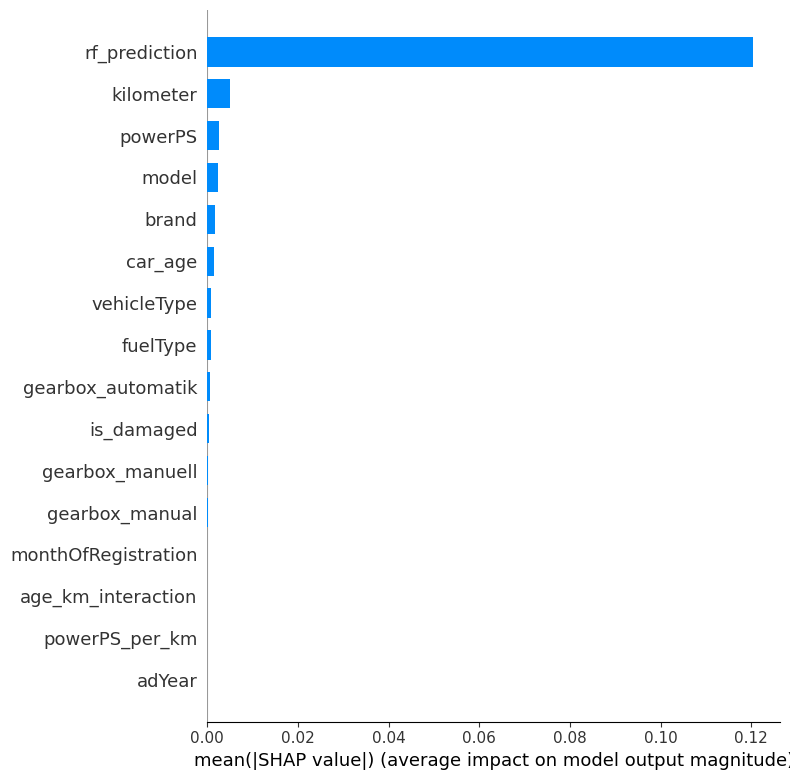

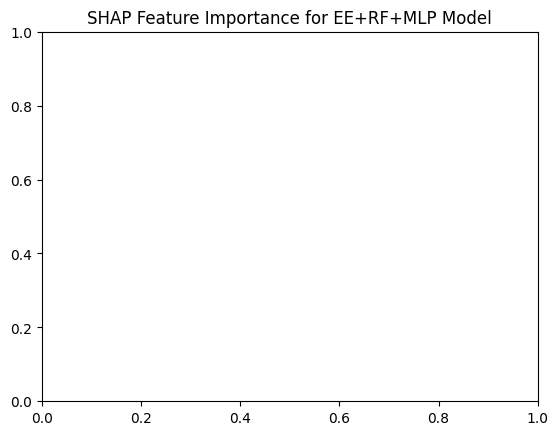

Average predicted price (scaled): 0.1344
Average predicted price: 5,000.90 euros
Average actual price (subset): 5,812.12 euros

Feature: brand



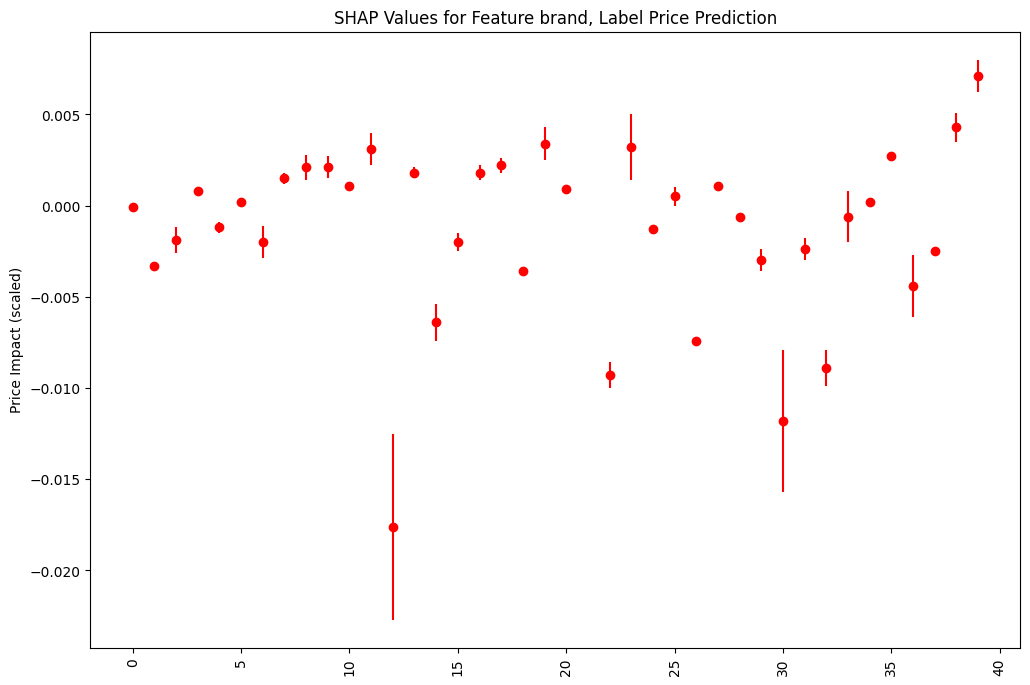

        gain  gain_std  count
col                          
39.0  0.0071    0.0009      2
38.0  0.0043    0.0008      2
19.0  0.0034    0.0009     52
23.0  0.0032    0.0018     10
11.0  0.0031    0.0009      9
35.0  0.0027       NaN      1
17.0  0.0022    0.0004      9
8.0   0.0021    0.0007     16
9.0   0.0021    0.0006     90
13.0  0.0018    0.0003      9
16.0  0.0018    0.0004     25
7.0   0.0015    0.0003     26
27.0  0.0011    0.0001      2
10.0  0.0011    0.0002      6
20.0  0.0009    0.0002      9
3.0   0.0008    0.0002     76
25.0  0.0005    0.0005      7
34.0  0.0002    0.0001      4
5.0   0.0002    0.0002    231
0.0  -0.0001    0.0001     16
28.0 -0.0006    0.0001     10
33.0 -0.0006    0.0014      4
4.0  -0.0012    0.0003    109
24.0 -0.0013    0.0002     18
2.0  -0.0019    0.0007    106
15.0 -0.0020    0.0005      5
6.0  -0.0020    0.0009     87
31.0 -0.0024    0.0006     10
37.0 -0.0025       NaN      1
29.0 -0.0030    0.0006      6
1.0  -0.0033    0.0002     12
18.0 -0.00

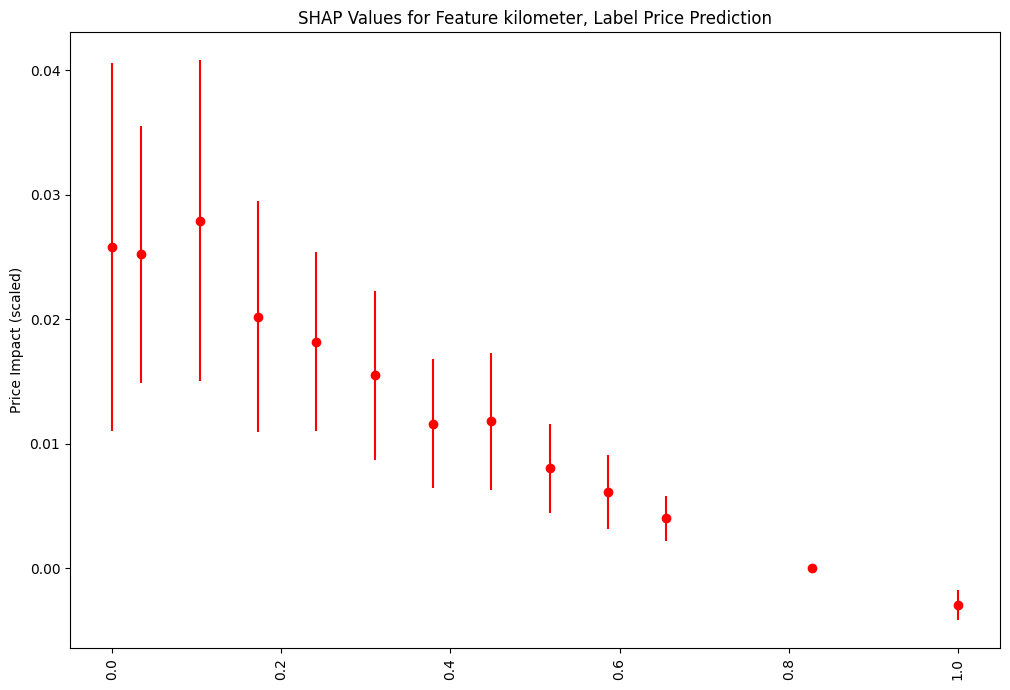

            gain  gain_std  count
col                              
0.103448  0.0279    0.0129     17
0.000000  0.0258    0.0148     16
0.034483  0.0252    0.0103      5
0.172414  0.0202    0.0093     19
0.241379  0.0182    0.0072     20
0.310345  0.0155    0.0068     19
0.448276  0.0118    0.0055     25
0.379310  0.0116    0.0052     16
0.517241  0.0080    0.0036     30
0.586207  0.0061    0.0030     38
0.655172  0.0040    0.0018     41
0.827586  0.0000    0.0001    103
1.000000 -0.0030    0.0012    651

Feature: car_age



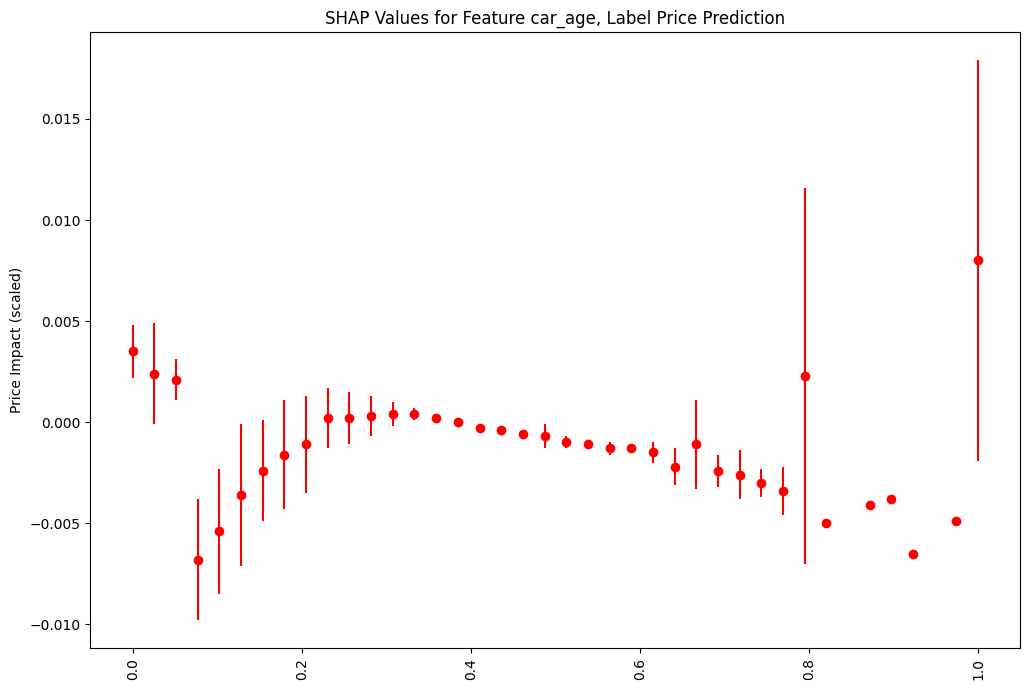

            gain  gain_std  count
col                              
1.000000  0.0080    0.0099     15
0.000000  0.0035    0.0013     11
0.025641  0.0024    0.0025     27
0.794872  0.0023    0.0093      2
0.051282  0.0021    0.0010     23
0.307692  0.0004    0.0006     61
0.333333  0.0004    0.0003     50
0.282051  0.0003    0.0010     47
0.256410  0.0002    0.0013     56
0.358974  0.0002    0.0001     53
0.230769  0.0002    0.0015     41
0.384615 -0.0000    0.0000     55
0.410256 -0.0003    0.0001     59
0.435897 -0.0004    0.0002     49
0.461538 -0.0006    0.0002     76
0.487179 -0.0007    0.0006     56
0.512821 -0.0010    0.0003     52
0.205128 -0.0011    0.0024     34
0.666667 -0.0011    0.0022      9
0.538462 -0.0011    0.0002     45
0.589744 -0.0013    0.0002     18
0.564103 -0.0013    0.0003     25
0.615385 -0.0015    0.0005     12
0.179487 -0.0016    0.0027     32
0.641026 -0.0022    0.0009      4
0.153846 -0.0024    0.0025     21
0.692308 -0.0024    0.0008      8
0.717949 -0.00

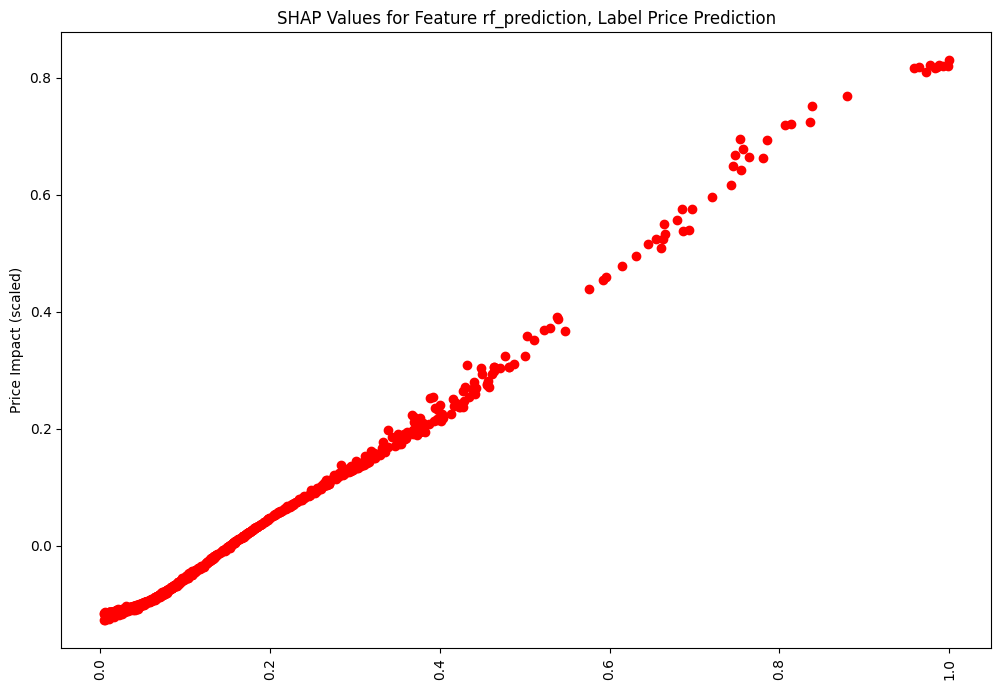

            gain  gain_std  count
col                              
0.999605  0.8297       NaN      1
0.977576  0.8221       NaN      1
0.988210  0.8219       NaN      1
0.998472  0.8206       NaN      1
0.992549  0.8200       NaN      1
...          ...       ...    ...
0.017168 -0.1204       NaN      1
0.017216 -0.1216       NaN      1
0.011318 -0.1253       NaN      1
0.004662 -0.1263       NaN      1
0.005967 -0.1275       NaN      1

[997 rows x 3 columns]


In [ ]:
# Cell 9.5: SHAP Analysis for Interpretability (Debugged)

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize SHAP for visualization
shap.initjs()

# Prepare a subset of the test data for SHAP
subset_size = 1000
X_test_subset = [X_test['brand'].values[:subset_size],
                 X_test['model'].values[:subset_size],
                 X_test['vehicleType'].values[:subset_size],
                 X_test['fuelType'].values[:subset_size],
                 X_test[num_cols].values[:subset_size],
                 rf_test_preds[:subset_size].reshape(-1, 1)]

# Convert to a single array for SHAP
X_test_subset_stacked = np.hstack([arr.reshape(len(arr), -1) for arr in X_test_subset])
print("Shape of X_test_subset_stacked:", X_test_subset_stacked.shape)

# Summarize the background data using k-means clustering (100 samples)
background_data = shap.kmeans(X_test_subset_stacked, 100)
print("Shape of background_data.data:", background_data.data.shape)  # Fixed: Access the data attribute

# Feature names for visualization
feature_names = ['brand', 'model', 'vehicleType', 'fuelType'] + num_cols + ['rf_prediction']
print("Feature names:", feature_names)

# Define a function to wrap the EE+RF+MLP model for SHAP
def model_predict(inputs):
    split_indices = [1, 1, 1, 1, len(num_cols), 1]
    cum_indices = np.cumsum(split_indices)[:-1]
    inputs_split = np.split(inputs, cum_indices, axis=1)
    preds = ee_rf_mlp.predict(inputs_split, verbose=0).flatten()
    return preds

# Test the model_predict function
test_preds = model_predict(X_test_subset_stacked)
print("Sample predictions from model_predict:", test_preds[:5])

# Use KernelExplainer with the summarized background data
explainer = shap.KernelExplainer(model_predict, background_data)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_subset_stacked, nsamples=500)
print("Shape of shap_values:", np.array(shap_values).shape)
print("Sample SHAP values:", shap_values[:5])

# Check if SHAP values are non-zero
print("Mean absolute SHAP values per feature:", np.abs(shap_values).mean(axis=0))

# Summary plot (bar plot of feature importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, features=X_test_subset_stacked, feature_names=feature_names, plot_type="bar")
plt.title("SHAP Feature Importance for EE+RF+MLP Model")
plt.show()

# Expected value (average prediction)
expected_value = explainer.expected_value
print(f"Average predicted price (scaled): {expected_value:.4f}")
avg_pred_price = price_scaler.inverse_transform([[expected_value]])[0][0]
print(f"Average predicted price: {avg_pred_price:,.2f} euros")

# Average actual price
avg_actual_price = price_scaler.inverse_transform(y_test.reshape(-1, 1))[:subset_size].mean()
print(f"Average actual price (subset): {avg_actual_price:,.2f} euros")

# Function to visualize SHAP values for a specific feature
def show_shap(col, shap_values=shap_values, label="Price Prediction", X_test=X_test_subset_stacked, ylabel='Price Impact (scaled)'):
    df_infl = pd.DataFrame(X_test, columns=feature_names)
    col_idx = feature_names.index(col)
    df_infl['shap_'] = shap_values[:, col_idx]

    gain = df_infl.groupby(col)['shap_'].mean().round(4)
    gain_std = df_infl.groupby(col)['shap_'].std().round(4)
    cnt = df_infl.groupby(col)['shap_'].count()

    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')

    plt.figure(figsize=(12, 8))
    plt.errorbar(df_res.index, df_res['gain'].values, yerr=df_res['gain_std'].values, fmt="o", color="r")
    plt.title(f'SHAP Values for Feature {col}, Label {label}')
    plt.ylabel(ylabel)
    plt.tick_params(axis="x", rotation=90)
    plt.show()
    print(df_res)

# Visualize SHAP values for key features
for col in ['brand', 'kilometer', 'car_age', 'rf_prediction']:
    print(f"\nFeature: {col}\n")
    show_shap(col)